In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage import io
from torch.utils.data import Dataset, DataLoader

from src.settings import DATA_DIRECTORY

In [17]:
class UcMercedDataset(Dataset):
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
        self.class_names = sorted([path for path in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, path))])
        self.label_name_mapping = dict(enumerate(self.class_names))
        self.name_label_mapping = { class_name: label for label, class_name in self.label_name_mapping.items() }
        self.positive_mapping = { }
        image_paths = []
        y = []
        for class_name in self.class_names:
            class_path = os.path.join(self.root_dir, class_name)
            class_image_paths = []
            for file_name in os.listdir(class_path):
                path = os.path.join(self.root_dir, class_name, file_name)
                if os.path.isfile(path):
                    img = io.imread(path)
                    if img.shape[:2] == (256, 256):
                        class_image_paths.append(path)
            self.positive_mapping[self.name_label_mapping[class_name]] = np.arange(len(image_paths), len(image_paths) + len(class_image_paths))
            image_paths.extend(class_image_paths)
            y.extend([self.name_label_mapping[class_name]] * len(class_image_paths))
        self.image_paths = np.array(image_paths)
        self.y = np.array(y)
        all_indices = np.arange(len(self.image_paths))

        self.negative_mapping = {
            class_label: all_indices[~np.in1d(all_indices, positive)]
            for class_label, positive in self.positive_mapping.items()
        }

    def __len__(self):
        return self.image_paths.shape[0]

    def get_positive(self, anchor_index):
        return self.get_sample(self.positive_mapping, anchor_index)

    def get_negative(self, anchor_index):
        return self.get_sample(self.negative_mapping, anchor_index)

    def get_sample(self, mapping_dict, y):
        idx = int(np.random.choice(mapping_dict[y]))
        return idx

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        def read_image(idx):
            print(idx)
            img_name = self.image_paths[idx]
            return io.imread(img_name)

        y = self.y[idx]
        anchor = read_image(idx)
        p_id = self.get_positive(y)
        n_id = self.get_negative(y)
        positive = read_image(self.get_positive(p_id))
        negative = read_image(self.get_negative(n_id))
        positive_y = self.y[p_id]
        negative_y = self.y[n_id]


        sample = {'a': anchor, 'p': positive, 'n': negative, 'a_y': y, 'p_y': positive_y, 'n_y': negative_y }
        return sample

    def get_label_mapping(self, id):
        return self.label_name_mapping[id]

In [18]:
dset = UcMercedDataset(DATA_DIRECTORY)


0
51 1297
72
689

1
36 448
7
1735


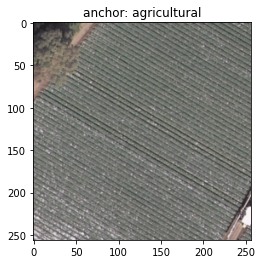

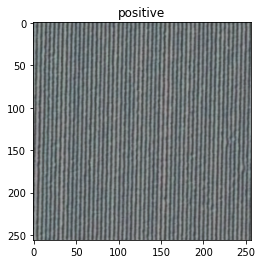

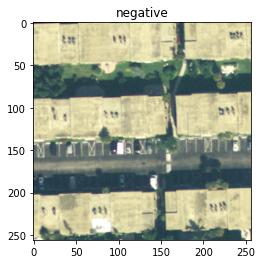

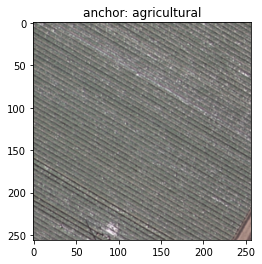

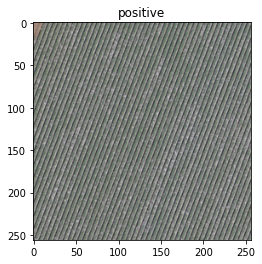

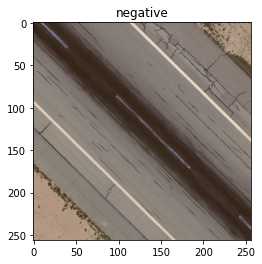

In [16]:
for i in range(len(dset)):
    print()
    sample = dset[i]

    plt.tight_layout()
    plt.title(f"anchor: {dset.get_label_mapping(sample['a_y'])}")
    plt.imshow(sample['a'])
    plt.show()

    plt.tight_layout()
    plt.title("positive")
    plt.imshow(sample['p'])
    plt.show()

    plt.tight_layout()
    plt.title("negative")
    plt.imshow(sample['n'])
    plt.show()

    if i == 1:
        break

In [ ]:
dataloader = DataLoader(dset, batch_size=4,
                        shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    images = sample_batched['x']
    labels = sample_batched['y']
    for x, y in zip(images, labels):
        plt.tight_layout()
        plt.title(f'{dset.get_label_mapping(y.item())}')
        plt.imshow(x)
        plt.show()
    break
